### Load things

In [ ]:
import h5py as h5
import matplotlib.pyplot as plt
import os
import configparser
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import sys
sys.path.append(os.path.expanduser("~/auton-survival"))
from auton_survival.preprocessing import Scaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ParameterGrid
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from auton_survival.models.dsm import DeepSurvivalMachines
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
from get_survival_from_shot import get_rt_survival_from_shot, get_cakenn_survival_from_shot
import copy

path = '/projects/EKOLEMEN/survival_tm_2/'

### Settings

In [10]:
config_name = 'model.cfg'
time_horizon = 1000
wanted_shot = '180637'

### Load database

In [199]:
# READ CONFIG
config = configparser.ConfigParser()
config.read(config_name)
database_x_name = config['model']['database_x_name']
database_e_name = config['model']['database_e_name']
database_t_name = config['model']['database_t_name']
database_shots_list_name = config['model']['database_shots_list_name']
output_filename_base = config['model']['output_filename_base']

# LOAD DATABASE
with open(path+f'data/{database_x_name}.pkl', 'rb') as f:
    x = pickle.load(f)
with open(path+f'data/{database_e_name}.pkl', 'rb') as f:
    e = pickle.load(f)
with open(path+f'data/{database_t_name}.pkl', 'rb') as f:
    t = pickle.load(f)
with open(path+f'data/{database_shots_list_name}.pkl', 'rb') as f:
    shots_list = pickle.load(f)

# LOAD MODEL
with open(path+f'models/{output_filename_base}.pkl', 'rb') as f:
    model = pickle.load(f)[0][0]

# Basic Examples

### Run model

In [63]:
survival_output = model.predict_survival(x, [time_horizon])

/home/ar0535/auton-survival/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


### Plot output

Text(0.5, 1.0, 'Shot 180637')

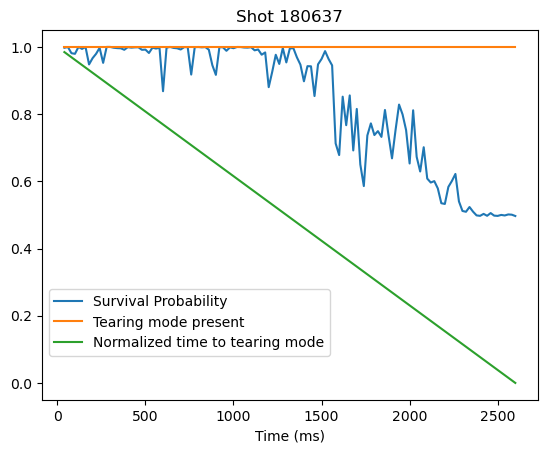

In [64]:
# FIND START AND END OF WANTED SHOT IN DATABASE
start_index = np.where(shots_list == wanted_shot)[0][0]
end_index = len(shots_list) - 1 - np.where(shots_list[::-1] == wanted_shot)[0][0]
x_shot = x[start_index:end_index]
t_shot = t[start_index:end_index][::-1]
survival_output_shot = survival_output[start_index:end_index]

plt.plot(t_shot, survival_output_shot, label='Survival Probability')
plt.plot(t_shot, e[start_index:end_index], label='Tearing mode present')
plt.plot(t_shot, 1-t_shot/t_shot.max(), label='Normalized time to tearing mode')
plt.xlabel('Time (ms)')
plt.legend(loc='lower left', bbox_to_anchor=(0, 0.1))
plt.title(f'Shot {wanted_shot}')

### Code to get outputs from either model

In [65]:
# CAKENN example
cakenn_times, cakenn_survival_output, cakenn_x = get_cakenn_survival_from_shot('199598', '199596199610_data_outputs', 'recent_data_scalars199596_199610', 'cake_normalizations_dict', 'cakenn_norm_fixed', 1000)

# RT example
rt_times, rt_survival_output, rt_x = get_rt_survival_from_shot('180637', 'recent_data180634_180640', 'rt_normalizations_dict', 'rt_fixed_rot_large', 1000)

FileNotFoundError: [Errno 2] No such file or directory: 'data/199596199610_data_outputs.pkl'

# PCA Analysis

In [192]:
with open('/projects/EKOLEMEN/survival_tm/cakenn_filtered_pca_components_bms_pcb.pkl', 'rb') as f:
        normalizations = pickle.load(f)

In [37]:
te_pca = normalizations[0]
ti_pca = normalizations[2]
ne_pca = normalizations[4]
rot_pca = normalizations[6]
iota_pca = normalizations[8]
pres_pca = normalizations[10]
j_phi_pca = normalizations[12]

### Plot PCA components

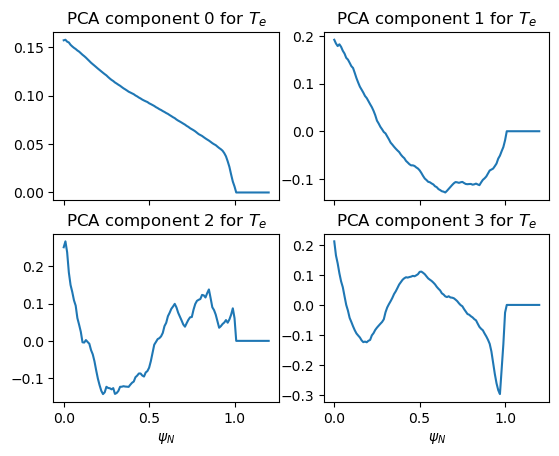

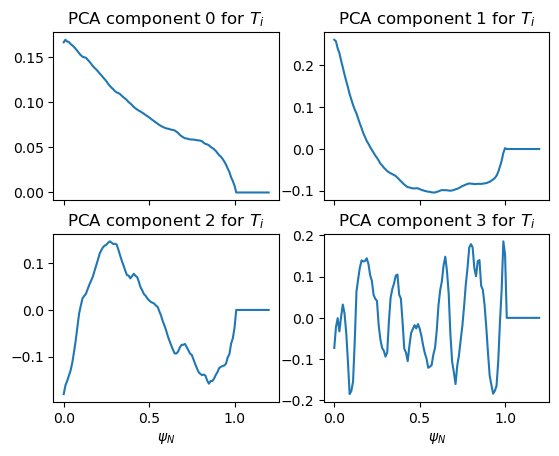

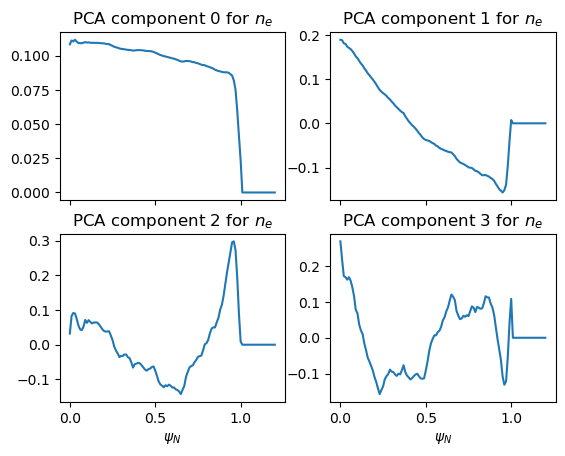

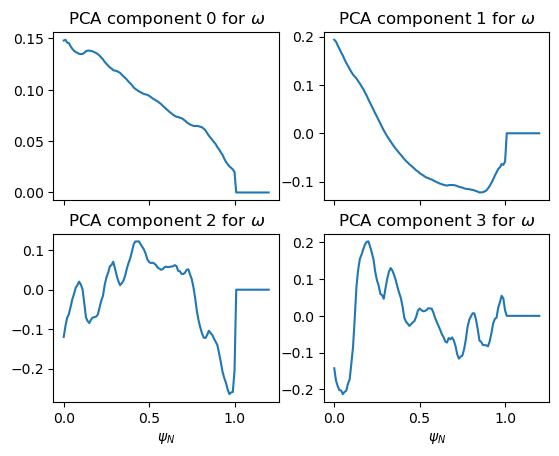

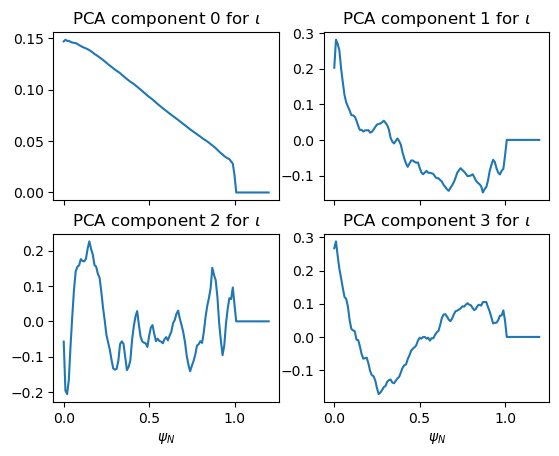

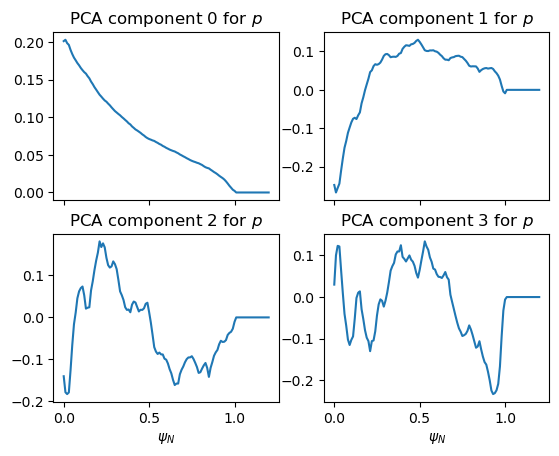

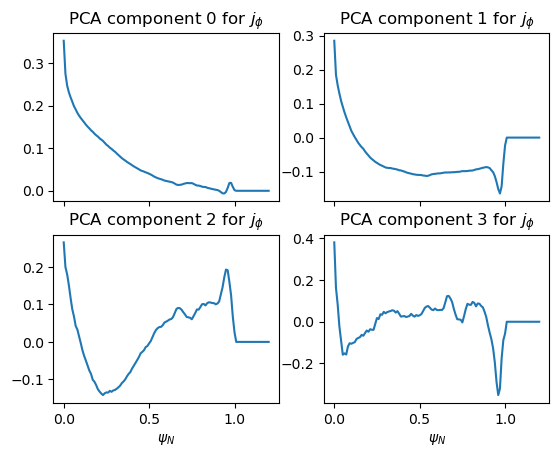

In [59]:
pcas = [te_pca, ti_pca, ne_pca, rot_pca, iota_pca, pres_pca, j_phi_pca]
names = [r'$T_e$', r'$T_i$', r'$n_e$', r'$\omega$', r'$\iota$', r'$p$', r'$j_\phi$']

for j,pca in enumerate(pcas):
    fig, axs = plt.subplots(2, 2, sharex=True)

    for i in range(4):
        axs[int(i/2), i%2].plot(np.linspace(0,1.2, 121), pca[i,:])
        axs[int(i/2), i%2].set_title(rf'PCA component {i} for {names[j]}')

    axs[1,0].set_xlabel(r'$\psi_N$')
    axs[1,1].set_xlabel(r'$\psi_N$')
    plt.show();

### Scalar PCA profile analysis

In [92]:
def remove_outliers(data, threshold=5):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = (data - mean) / std
    filtered_data = data[np.abs(z_scores) < threshold]
    return filtered_data

/tmp/ipykernel_3012947/3858699438.py:26: RuntimeWarning: divide by zero encountered in divide
  unstable_errors = 1/np.sqrt(unstable_counts)
/tmp/ipykernel_3012947/3858699438.py:27: RuntimeWarning: divide by zero encountered in divide
  stable_errors = 1/np.sqrt(stable_counts)


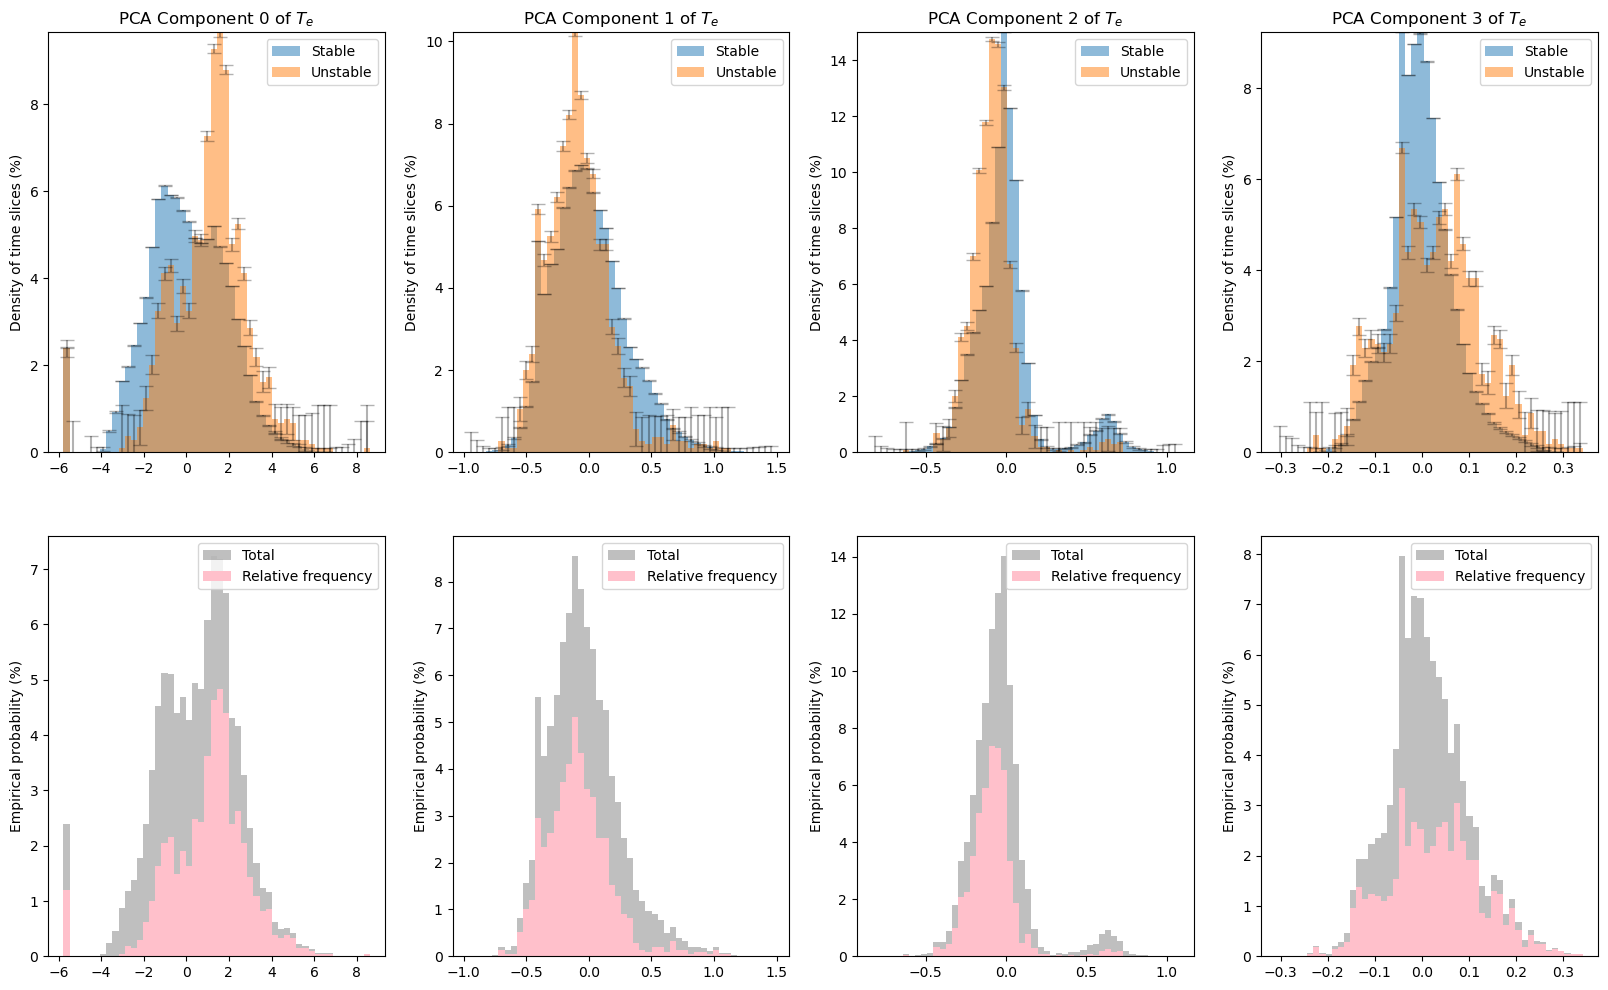

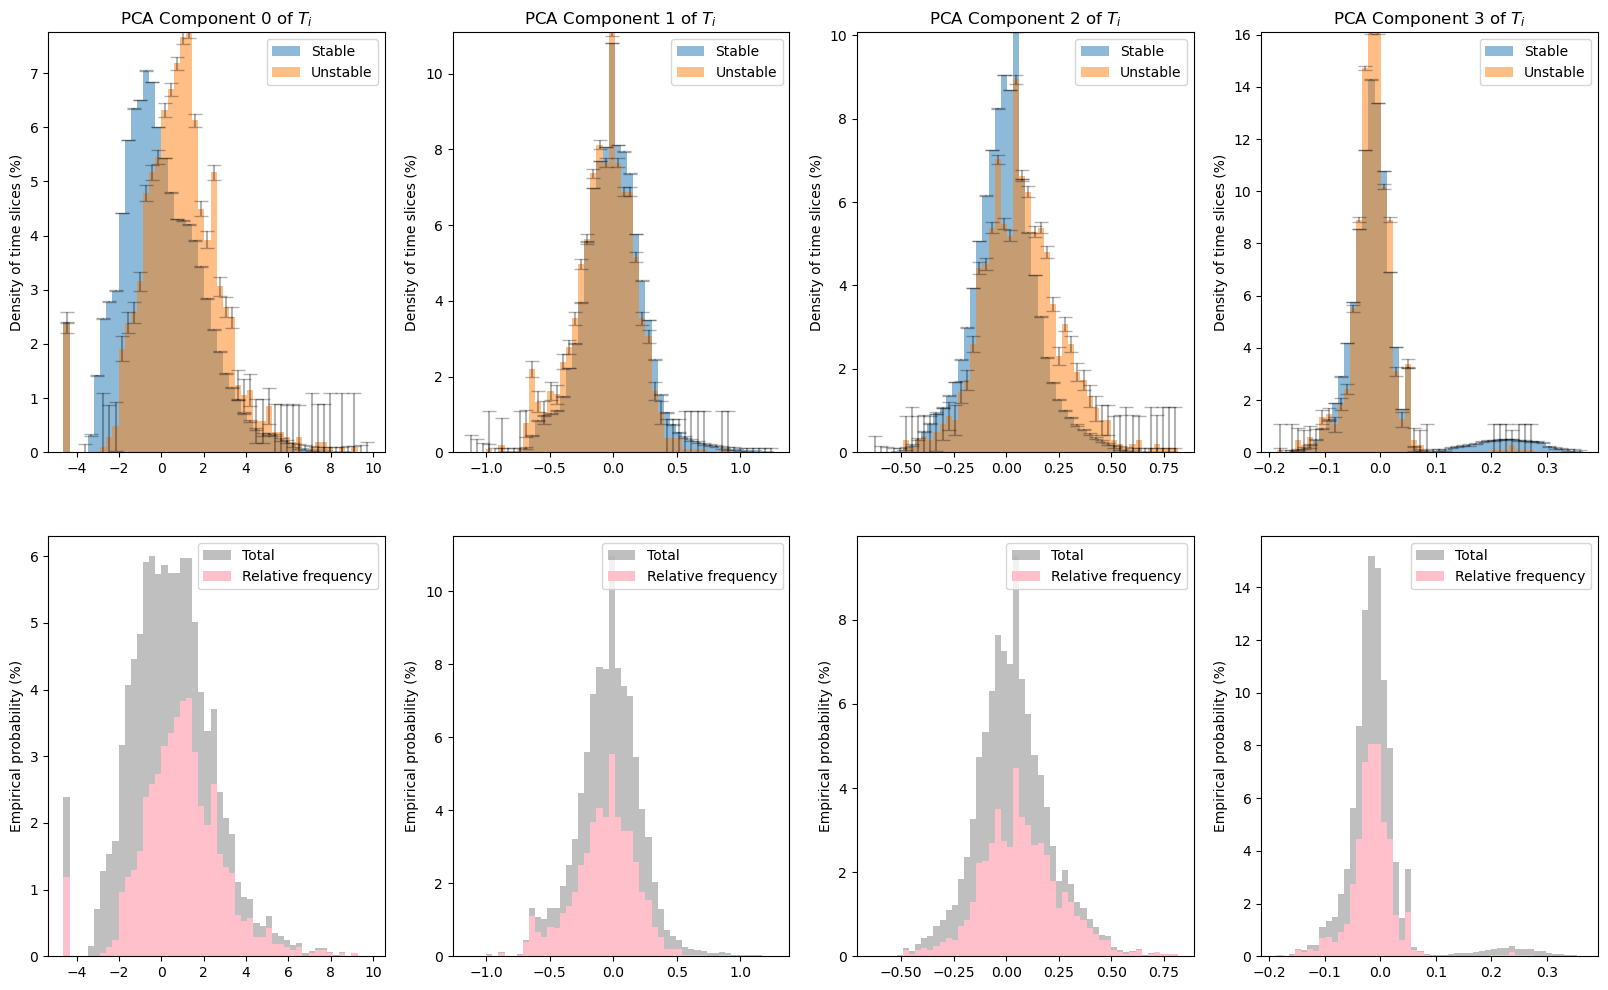

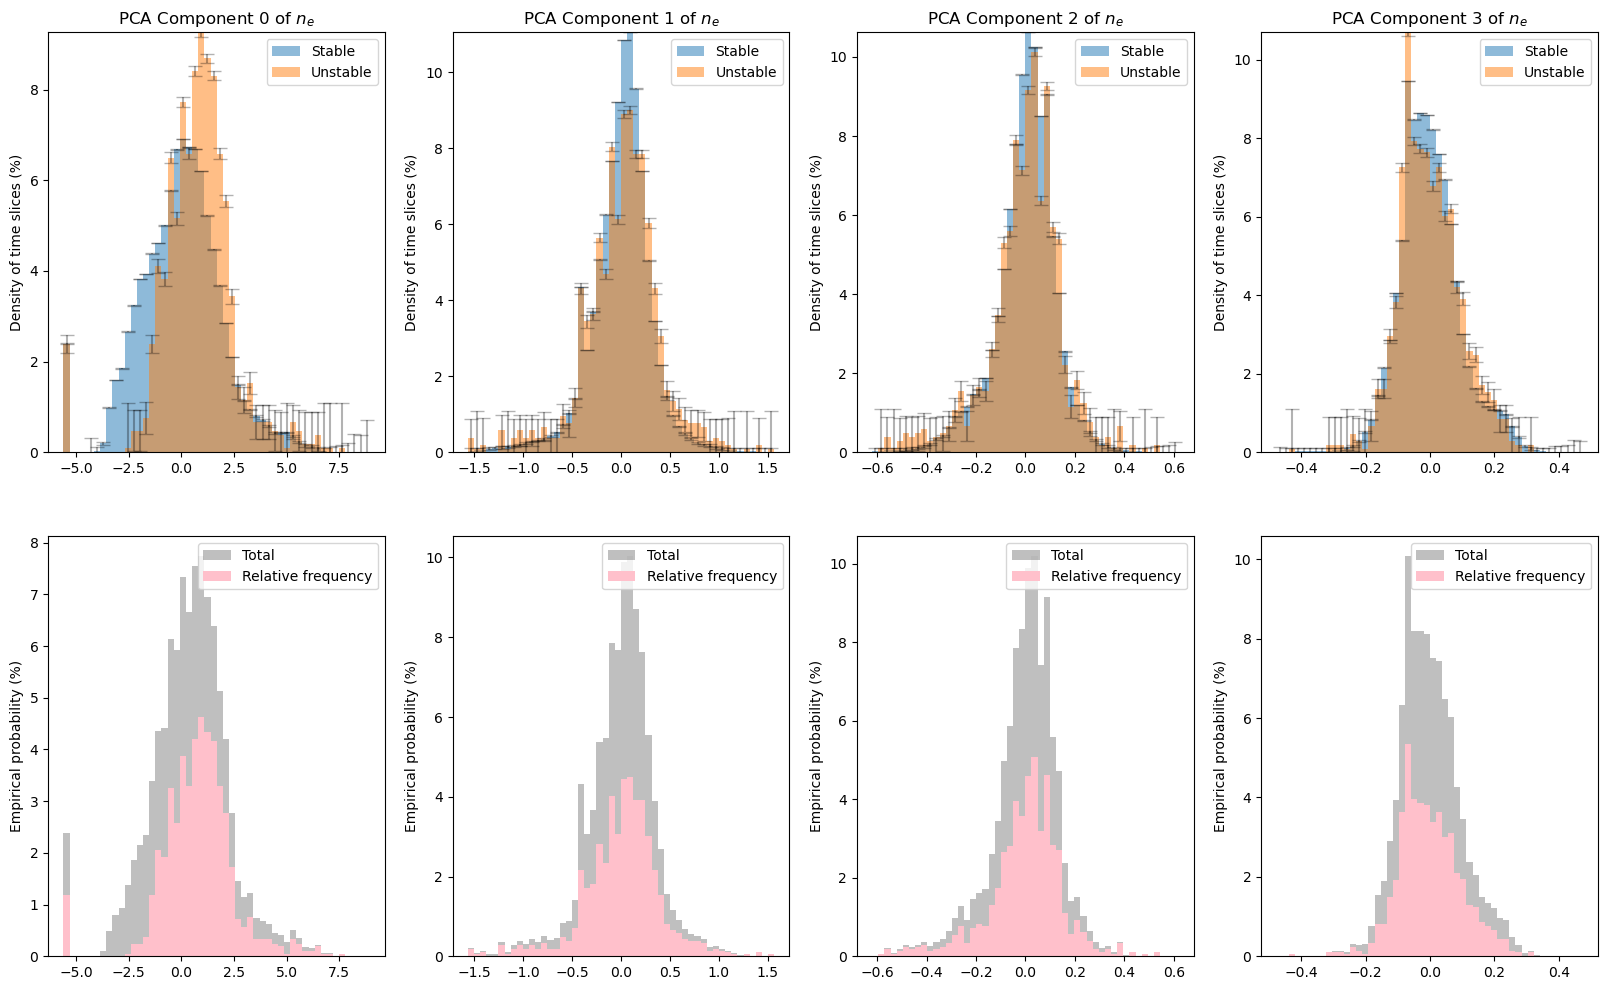

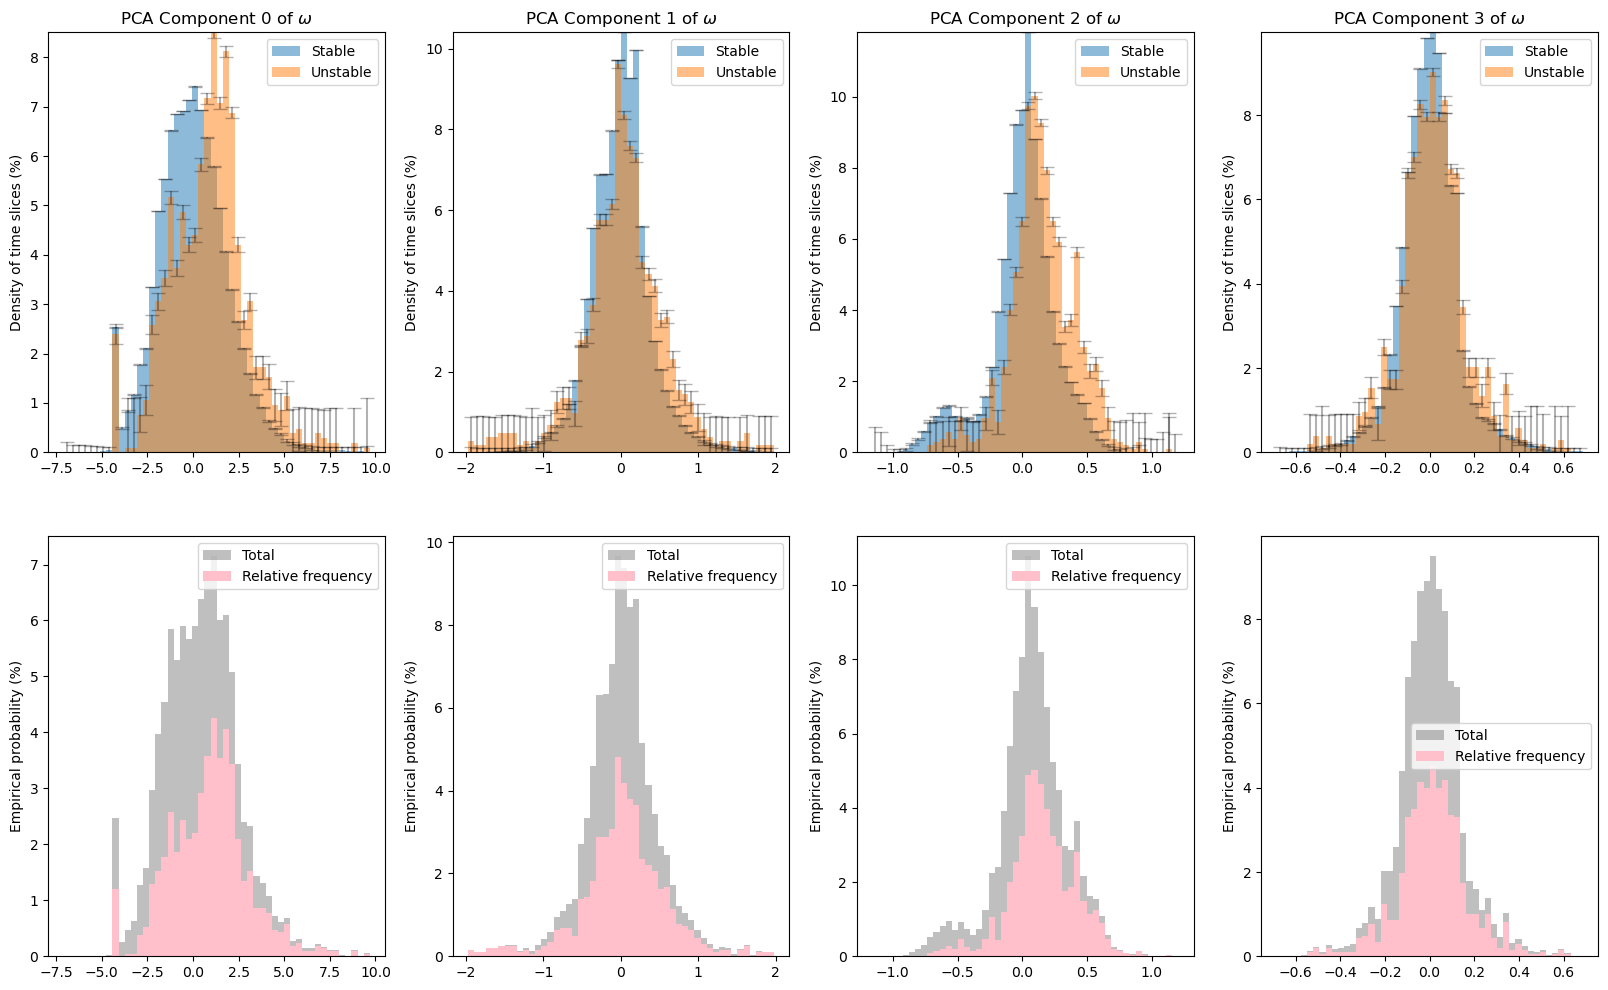

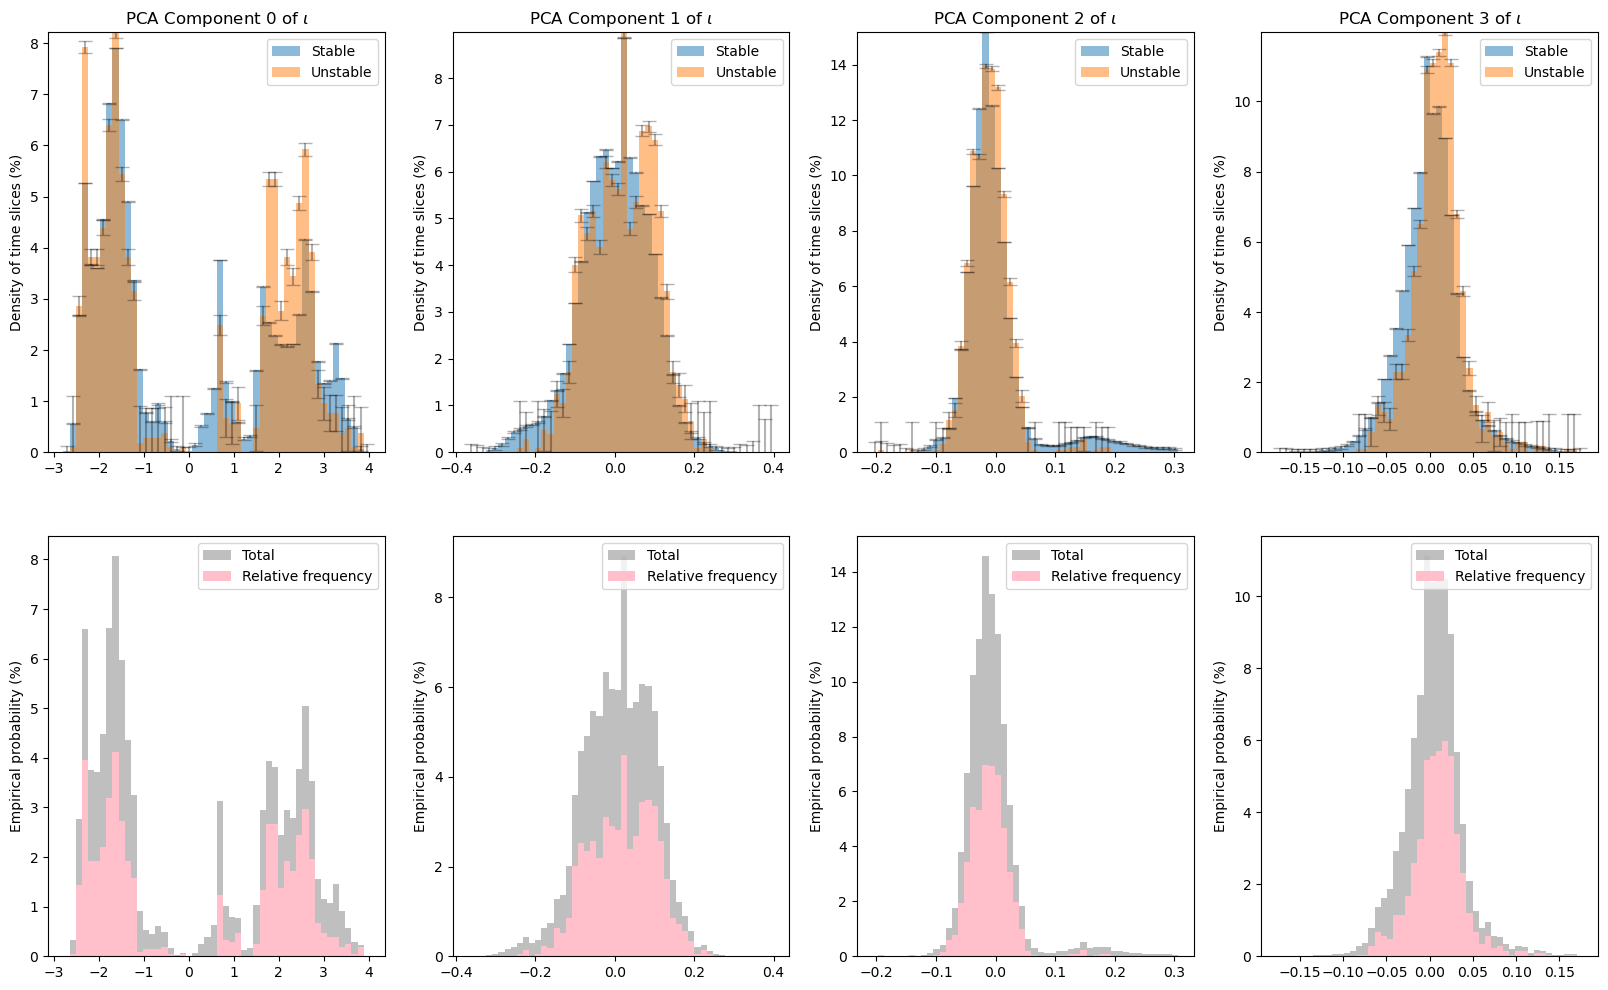

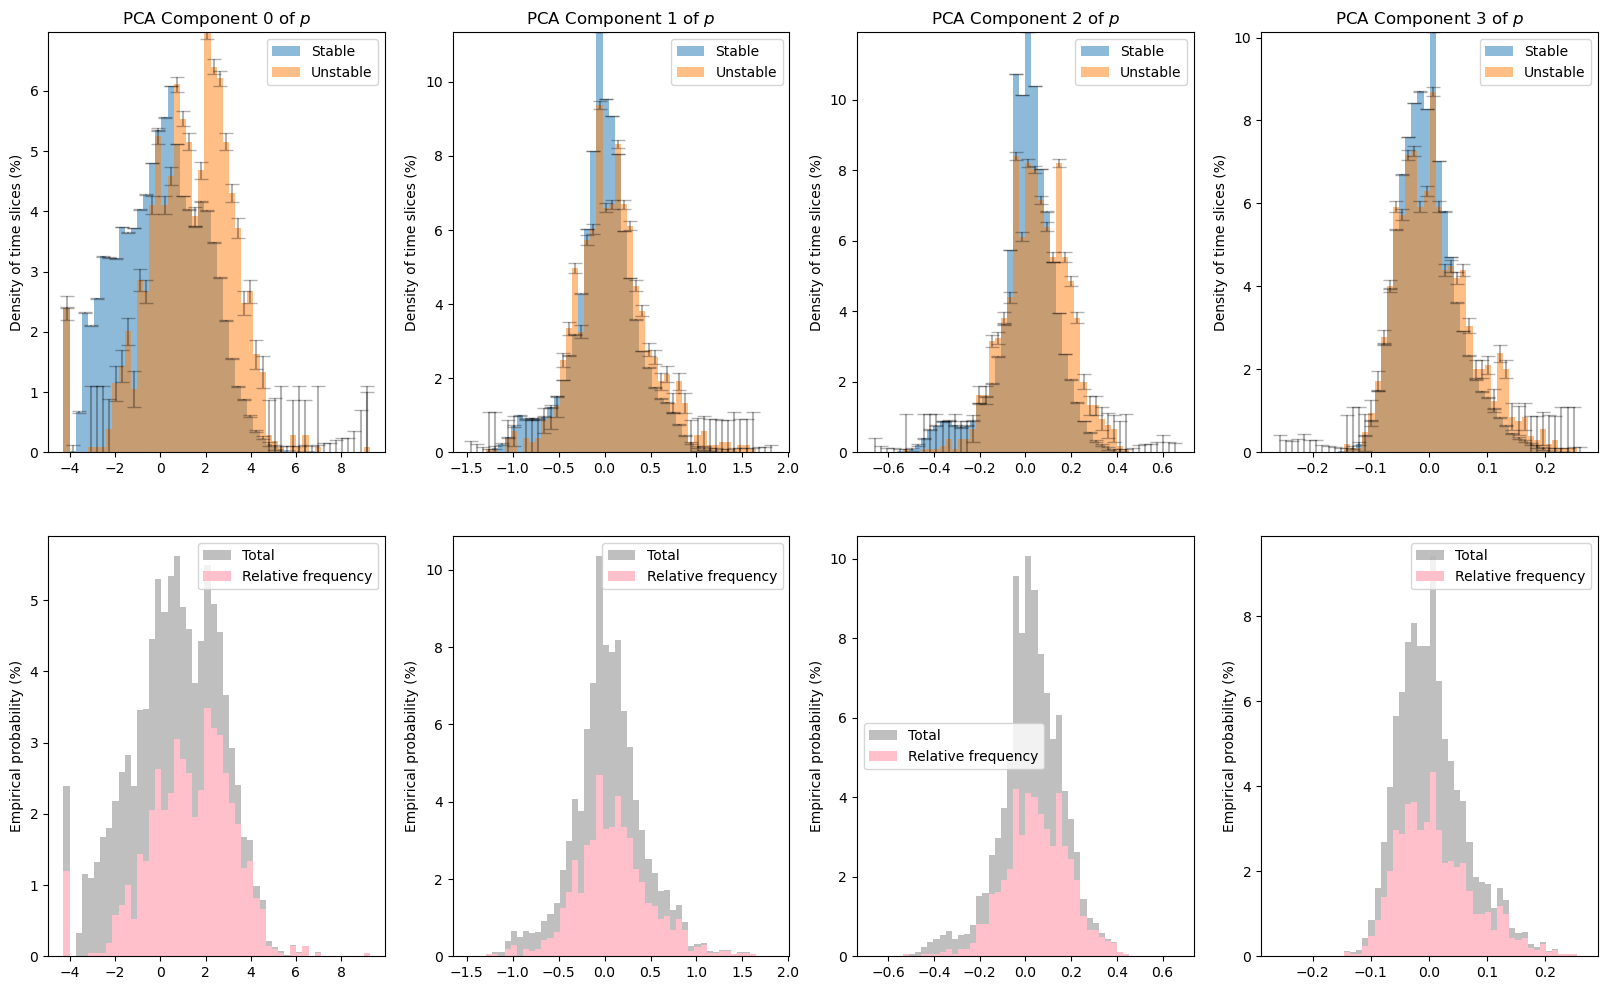

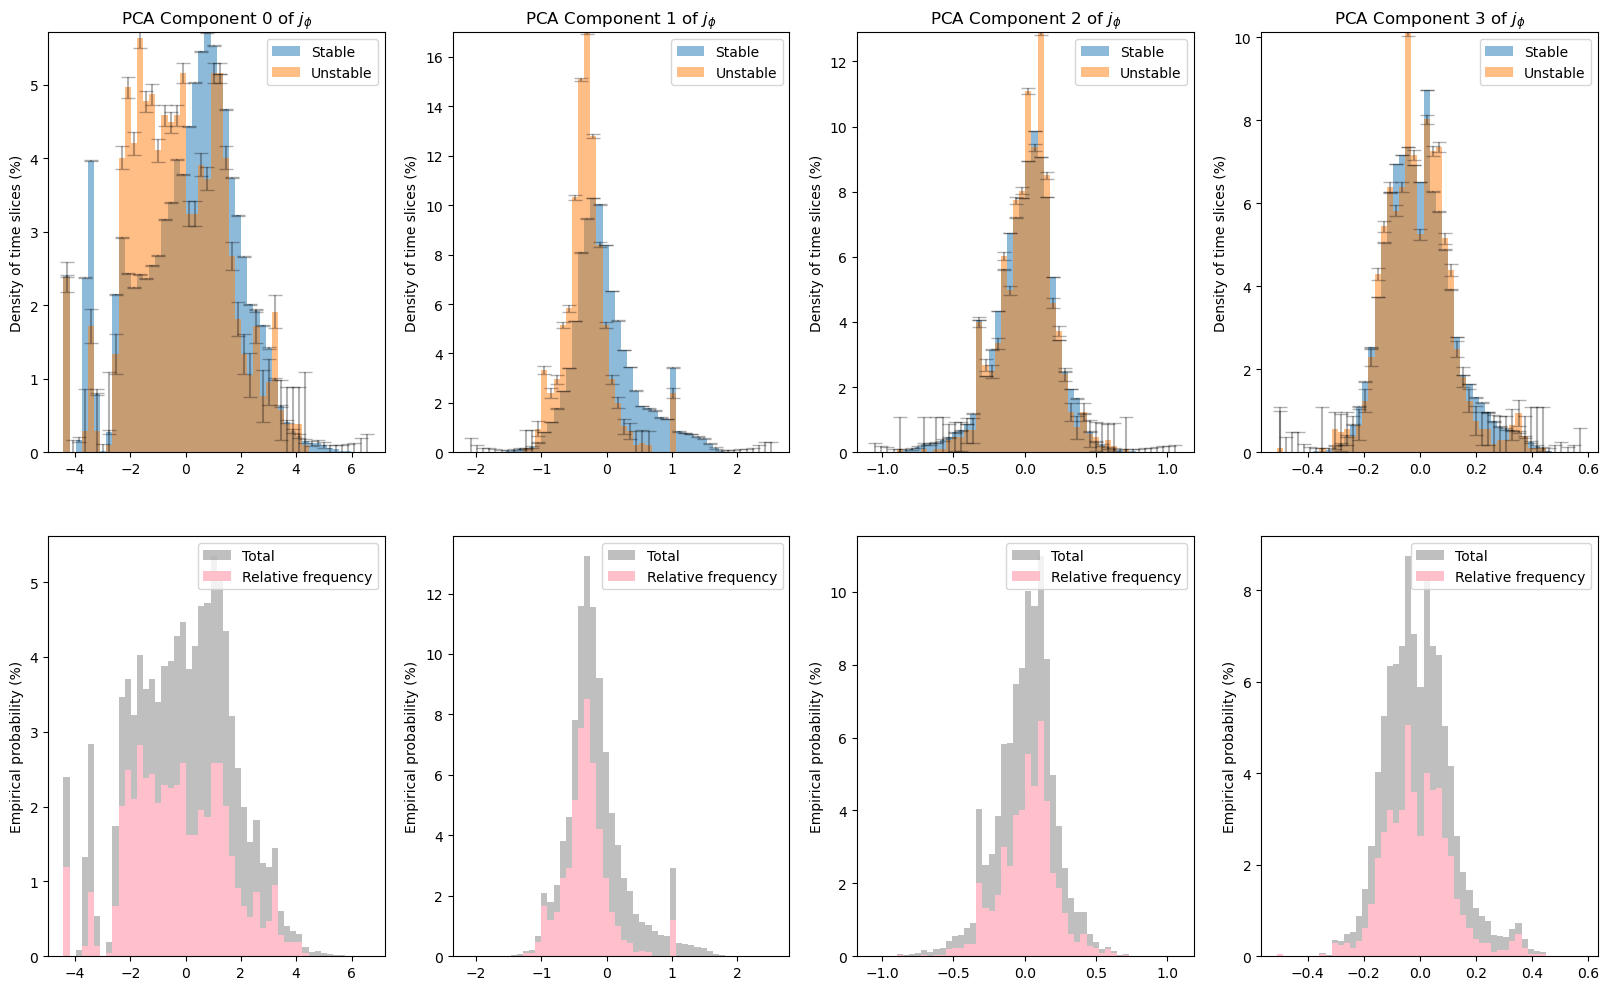

In [ ]:
num_bins = 50

# This makes only last time slices before TM onset have TM onset label, should comment out if don't want this
"""
for i in range(len(e)):
    if e[i] == 1:
        if t[i] > 20:
            e[i] = 0
"""

for name_ind in range(7):
    ind = 14 + 4*name_ind
    names = [r'$T_e$', r'$T_i$', r'$n_e$', r'$\omega$', r'$\iota$', r'$p$', r'$j_\phi$']

    fig, axs = plt.subplots(2, 4, figsize=(20,12))

    for pca_comp in range(4):
        x_noout = remove_outliers(x[:][ind+pca_comp])
        unstable = x[e.astype(bool)][ind+pca_comp]
        stable = x[~e.astype(bool)][ind+pca_comp]

        unstable = remove_outliers(unstable)
        stable = remove_outliers(stable)

        unstable_counts, unstable_bins = np.histogram(unstable, bins=num_bins, range=(x_noout.min(), x_noout.max()), density=False)
        stable_counts, stable_bins = np.histogram(stable, bins=num_bins, range=(x_noout.min(), x_noout.max()), density=False)

        unstable_errors = 1/np.sqrt(unstable_counts)
        stable_errors = 1/np.sqrt(stable_counts)

        unstable_density = 100*unstable_counts / np.sum(unstable_counts)
        stable_density = 100*stable_counts / np.sum(stable_counts)

        bin_centers = (unstable_bins[:-1] + unstable_bins[1:]) / 2

        axs[0,pca_comp].stairs(stable_density, stable_bins, label='Stable', fill=True, alpha=0.5)
        axs[0,pca_comp].stairs(unstable_density, unstable_bins, label='Unstable', fill=True, alpha=0.5)
        axs[0,pca_comp].errorbar(bin_centers, unstable_density, yerr=unstable_errors, fmt='none', ecolor='black', capsize=5, alpha=0.3)
        axs[0,pca_comp].errorbar(bin_centers, stable_density, yerr=stable_errors, fmt='none', ecolor='black', capsize=5, alpha=0.3)
        axs[0,pca_comp].set_title(rf'PCA Component {pca_comp} of {names[name_ind]}')
        axs[0,pca_comp].legend()
        axs[0,pca_comp].set_ylabel('Density of time slices (%)')
        axs[0,pca_comp].set_ylim(0, np.max([np.max(unstable_density), np.max(stable_density)]))

        axs[1,pca_comp].stairs(100*(unstable_density+stable_density) / np.sum([unstable_density, stable_density]), unstable_bins, label='Total', fill=True, alpha=0.5, color='grey')
        axs[1,pca_comp].stairs(100*unstable_density/np.sum([unstable_density, stable_density]), unstable_bins, label='Relative frequency', fill=True, alpha=1, color='pink')
        axs[1,pca_comp].set_ylabel('Empirical probability (%)')

        axs[1,pca_comp].legend()
    plt.show();